#   Comparison of a base KNN to a KNN w/ratings

In [126]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
import ast
import requests
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

In [127]:
response = requests.post('http://underdog-devs-ds-a-dev.us-east-1.elasticbeanstalk.com/Mentors/read')
mentors = pd.DataFrame(response.json()['result'])

In [128]:
response = requests.post('http://underdog-devs-ds-a-dev.us-east-1.elasticbeanstalk.com/Mentees/read')
mentees = pd.DataFrame(response.json()['result'])

One hot encoding dataset generated by local_utils

In [129]:
def ohe(mentors, mentees):

    mentors = mentors.drop(columns=['first_name', 'last_name',
                           'email', 'city', 'state', 'validateStatus', 'country'])

    mentors = pd.merge(mentors, pd.get_dummies(mentors, columns=['current_comp', 'experience_level', 'job_help', 'industry_knowledge',
                          'pair_programming', 'other_info', 'formerly_incarcerated', 'list_convictions', 'underrepresented_group', 'low_income']).fillna(0))

    mentors = mentors.join(mentors['subject'].apply(
        pd.Series).stack().str.get_dummies().groupby(level=0).sum())

    mentors = mentors.drop(columns=['subject', 'current_comp', 'experience_level', 'job_help', 'industry_knowledge',
                           'pair_programming', 'other_info', 'formerly_incarcerated', 'list_convictions', 'underrepresented_group', 'low_income'])
    
    mentors = mentors.set_index('profile_id')
    mentors.index.rename('mentors_profile_id', inplace=True)

    #------------------------------------------------------------

    mentees = mentees.drop(columns=['first_name', 'last_name',
                           'email', 'city', 'state', 'validateStatus', 'country', 'list_convictions'])

    mentees = pd.merge(mentees, pd.get_dummies(mentees, columns=['experience_level', 'job_help', 'industry_knowledge',
                          'pair_programming', 'other_info', 'formerly_incarcerated', 'underrepresented_group', 'low_income']).fillna(0))

    mentees = mentees.join(mentees['subject'].apply(
        pd.Series).stack().str.get_dummies().groupby(level=0).sum())
    mentees = mentees.drop(columns=['subject', 'experience_level', 'job_help', 'industry_knowledge',
                           'pair_programming', 'other_info', 'formerly_incarcerated', 'underrepresented_group', 'low_income'])

    mentees = mentees.set_index('profile_id')
    mentees.index.rename('mentees_profile_id', inplace=True)

    return mentors, mentees


In [130]:
#the driving force of selection is mentee to mentor <---- mentee like system
mentors, mentees = ohe(mentors, mentees)

# Generate a fake review matrix

In [145]:
#This needs to be changed to the review data from the live server eventually
reviews = sp.sparse.random(mentors.shape[0], mentees.shape[0], density=0.1, random_state=42)
reviews = pd.DataFrame(reviews.todense(), index=mentors.index, columns=mentees.index)
reviews = reviews.melt(ignore_index=False ,value_name='rating')

In [146]:
reviews

,mentees_profile_id,rating
mentors_profile_id,,
vDw14633y666xVTo,z781i5e3EhH82A7u,0.000000
H8L6d7kG2E1J8f58,z781i5e3EhH82A7u,0.000000
37T2KouYl5477V1o,z781i5e3EhH82A7u,0.000000
224Ks8ALel5OW253,z781i5e3EhH82A7u,0.000000
t82ZE41q1fHbx086,z781i5e3EhH82A7u,0.000000
...,...,...
cfz4dysa,9fhtw954,0.000000
cq972k0i,9fhtw954,0.279276
00u13oned0U8XP8Mb4x7,9fhtw954,0.000000


In [147]:
reviews_pivoted = reviews.pivot(columns = 'mentees_profile_id', values = 'rating').fillna(0)

In [148]:
reviews_pivoted

mentees_profile_id,001lJh12502oVmee,0AII175WS04xG1N3,0L3YtO8sC2555oS4,0xx22Xf564qn6Rp4,1138hHTZ32O02PMj,11cj8uT0kKwy7567,17f37I04BKdx82pJ,1D2wOOV6g2p7x575,1F5E6YYd85104yXT,207wj4XJoFOU7442,...,r18K6ih76OR7z61l,rB3tJ4323v2HzB57,vGd05Ag1v6548qv2,vuQ555270P4UBe2v,w82l1e4I43KVB31b,x8564JhRkaU72D60,xjDnK275381UU0R7,yh3i2p2M0e32h34o,z781i5e3EhH82A7u,z7p3E5F63KK8Z18u
mentors_profile_id,,,,,,,,,,,,,,,,,,,,,
0071UfJ4WLt18Z3F,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.572049,0.000000,0.0,0.000000
00u13oned0U8XP8Mb4x7,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.523330,0.000000,0.000000,0.152104,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
0lO7us717v3UI31U,0.0,0.000000,0.000000,0.000000,0.748826,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
224Ks8ALel5OW253,0.0,0.000000,0.000000,0.902453,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2gvkshpc,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.739904,0.881928,0.000000,0.000000,0.0,0.000000
37T2KouYl5477V1o,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.907195,0.000000,0.798380,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.882416,0.000000,0.0,0.000000
3e8pkv7m,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
6066s0sv35RnW5Eo,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.652224,0.000000,0.000000,0.0,0.000000
632KLg2a8I4yuH71,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.087093,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.384511,0.000000,0.0,0.000000


In [122]:
#merge the reviews on profile id
combined = reviews.merge(mentors, left_index=True, right_index=True)

In [135]:
wcss = []
silhouette_avg_n_clusters = []

for i in range(2, 80):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(mentees)
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(mentees, kmeans.fit_predict(mentees))
    silhouette_avg_n_clusters.append(silhouette_avg)

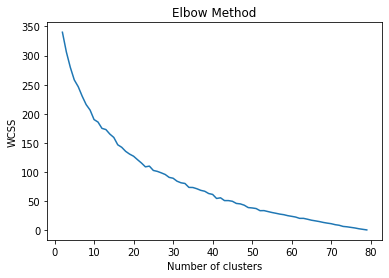

In [ ]:
plt.plot(range(2, 80), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

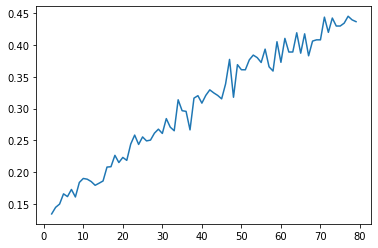

In [ ]:
plt.plot(range(2, 80), silhouette_avg_n_clusters)
plt.show()


In [140]:
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(mentees)

cluster_map = pd.DataFrame()
cluster_map.index = mentees.index.values
cluster_map["cluster"] = kmeans.labels_


In [141]:
cluster_dfs = []
for i in range(len(cluster_map["cluster"].unique())):
    cluster_dfs.append(
        cluster_map[cluster_map["cluster"] == i]
        .join(mentees).drop(columns=['cluster'])
    )


In [143]:
cluster_dfs[9]

,experience_level_Advanced,experience_level_Beginner,experience_level_Expert,experience_level_Intermediate,experience_level_expert,job_help_False,job_help_True,industry_knowledge_False,industry_knowledge_True,pair_programming_False,...,low_income_False,low_income_True,Android: Java,Career Development,Data Science: Python,General Programming,"Web: HTML, CSS, JavaScript",backend,career,iOS: Swift
ULH2qV8V48706CJ3,0,0,0,1,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
Hcc28h085A56oPi2,0,0,0,1,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
z7p3E5F63KK8Z18u,0,0,1,0,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
Y0Xe8up4M720lc75,0,0,0,1,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
E4aFq86N78IW640j,0,0,0,1,0,1,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
Y346cew713iUH0e1,0,0,0,1,0,1,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
ZTq8t41NAj62S303,0,0,0,1,0,1,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
WY3U44uq343AK8C3,0,0,0,1,0,1,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
64TB2r3s33ylO02B,0,0,0,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0


In [183]:
cluster_reviews = pd.DataFrame()

for mentees in cluster_dfs[9].index:
    cluster_reviews = pd.concat([cluster_reviews, reviews[reviews['mentees_profile_id'] == mentees]])

cluster_reviews_pivoted = cluster_reviews.pivot(columns = 'mentees_profile_id', values = 'rating').fillna(0) 
cluster_reviews

,mentees_profile_id,rating
mentors_profile_id,,
vDw14633y666xVTo,ULH2qV8V48706CJ3,0.0
H8L6d7kG2E1J8f58,ULH2qV8V48706CJ3,0.0
37T2KouYl5477V1o,ULH2qV8V48706CJ3,0.0
224Ks8ALel5OW253,ULH2qV8V48706CJ3,0.0
t82ZE41q1fHbx086,ULH2qV8V48706CJ3,0.0
...,...,...
cfz4dysa,64TB2r3s33ylO02B,0.0
cq972k0i,64TB2r3s33ylO02B,0.0
00u13oned0U8XP8Mb4x7,64TB2r3s33ylO02B,0.0


In [184]:
#KNN model
def create_model(df, neighbors_number):
    model = NearestNeighbors(n_neighbors=min(
        neighbors_number+1, df.shape[0]), metric='cosine')
    model.fit(df)
    return model

# Create a KNN with ratings + filtering and one without

In [231]:
#Create model
knn_collab = create_model(cluster_reviews_pivoted.T, neighbors_number=10)


#### Perhaps a better approach would be to filter the data further and then apply KNN based on rating so that the weights are focused more on ratings rather than looking at the distance of other features?

random mentee#6967999171653,Raiden,Jones,"['Career Preparation', 'Technical']","['PHP', 'React', 'C++']",Advanced,Mountain

In [232]:
cluster_reviews_pivoted.T

mentors_profile_id,0071UfJ4WLt18Z3F,00u13oned0U8XP8Mb4x7,0lO7us717v3UI31U,224Ks8ALel5OW253,2gvkshpc,37T2KouYl5477V1o,3e8pkv7m,6066s0sv35RnW5Eo,632KLg2a8I4yuH71,6gc4Q834RO1h8VT2,...,cfz4dysa,cq972k0i,k3U0su6268AGiS74,l46VW1FXE2lM1610,nSw27773p075eafo,ndt5997c,t3tvtsoh,t745a885ge47cHdr,t82ZE41q1fHbx086,vDw14633y666xVTo
mentees_profile_id,,,,,,,,,,,,,,,,,,,,,
64TB2r3s33ylO02B,0.000000,0.0,0.174881,0.012608,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.157955,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
E4aFq86N78IW640j,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.417761,0.000000,0.000000,0.0,0.422548,0.0,0.000000,0.000000,0.000000
Hcc28h085A56oPi2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.636401,0.000000,0.000000
ULH2qV8V48706CJ3,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.668573,0.0,0.0,...,0.000000,0.670732,0.610780,0.000000,0.0,0.000000,0.0,0.507412,0.000000,0.000000
WY3U44uq343AK8C3,0.000000,0.0,0.819064,0.000000,0.591697,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
Y0Xe8up4M720lc75,0.113838,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.276814,0.0,0.000000,0.0,0.000000,0.000000,0.000000
Y346cew713iUH0e1,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.872754,0.110989,0.971533,0.000000,0.0,0.000000,0.0,0.000000,0.825978,0.000000
ZTq8t41NAj62S303,0.000000,0.0,0.000000,0.000000,0.512668,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.314350,0.000000,0.000000
z7p3E5F63KK8Z18u,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.184225


In [233]:
knn_collab_test = pd.DataFrame(data = cluster_reviews_pivoted['E4aFq86N78IW640j'], index=cluster_reviews_pivoted.index)
knn_collab_test.T

mentors_profile_id,0071UfJ4WLt18Z3F,00u13oned0U8XP8Mb4x7,0lO7us717v3UI31U,224Ks8ALel5OW253,2gvkshpc,37T2KouYl5477V1o,3e8pkv7m,6066s0sv35RnW5Eo,632KLg2a8I4yuH71,6gc4Q834RO1h8VT2,...,cfz4dysa,cq972k0i,k3U0su6268AGiS74,l46VW1FXE2lM1610,nSw27773p075eafo,ndt5997c,t3tvtsoh,t745a885ge47cHdr,t82ZE41q1fHbx086,vDw14633y666xVTo
E4aFq86N78IW640j,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.417761,0.0,0.0,0.0,0.422548,0.0,0.0,0.0,0.0


In [234]:
#run a test on knn
#note that this returns MENTEES similar to the current mentee

dist_collab, indices_collab = knn_collab.kneighbors(knn_collab_test.T, 5)

In [235]:
indices_collab

array([[1, 3, 6, 4, 7]], dtype=int64)

In [237]:
collab_mentor_list = []
for index in indices_collab:
    collab_mentor_list.append(mentors.loc[combined.iloc[index].index])


In [244]:
collab_df = pd.DataFrame(collab_mentor_list[0])
collab_df

,current_comp_Amazin,current_comp_Amozonian,current_comp_Boogle,current_comp_Lahoo,current_comp_Macrohard,current_comp_Pineapple,current_comp_Poptrist,current_comp_Toyota,current_comp_Unemployed,experience_level_Advanced,...,low_income_True,Android: Java,Career Development,Data Science: Python,General Programming,"Web: HTML, CSS, JavaScript",backend,front end,frontend,iOS: Swift
mentors_profile_id,,,,,,,,,,,,,,,,,,,,,
00u13oned0U8XP8Mb4x7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
224Ks8ALel5OW253,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3e8pkv7m,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2gvkshpc,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
6066s0sv35RnW5Eo,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
